In [1]:
#!pip install --upgrade jax jaxlib flax

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

We define a complex MLP

In [2]:
# Define the model
class SimpleNN(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=32)
    self.dense2 = nn.Dense(features=2)

  def __call__(self, x):
    x = self.dense1(x)
    x = nn.gelu(x)
    x = self.dense2(x)
    return x

# Learning Functions over Projective Spaces

Projective spaces are defined by:
$$
\mathbb{P}_n = \frac{\mathbb{C}^{n+1} - \{\vec{0}\}}{\mathbb{C}^\ast}
$$

That is, we consider $(\mathbb{C}^{n+1})$, remove the origin, and identify up to a non-zero complex rescaling $(\vec{z} \sim \lambda \vec{z})$, with $(\vec{z} \in \mathbb{C}^{n+1} - \{\vec{0}\})$ and $\
\lambda \in \mathbb{C}^\ast)$.

A function over projective space is required to be invariant under projective rescalings:
$$
f(\vec{z}) = f(\lambda \vec{z}) \quad \forall \vec{z}, \lambda
$$

In [3]:
import pickle
with open("funcData.pkl", "rb") as f:
    inputs, outputs = pickle.load(f)

print(inputs[0],outputs[0])

[ 0.19395497 -1.7570837  -0.00396011 -0.44197065] [-0.22134964  0.10380346]


This data set is for a function on $\mathbb{P}_1$, and outputs a complex number $x+iy$, represented by $[x,y]$. The input is listed as $[\text{Re}(Z_0), \text{Re}(Z_1), \text{Im}(Z_0), \text{Im}(Z_1)]$.

100%|██████████| 1000/1000 [00:05<00:00, 173.97it/s]


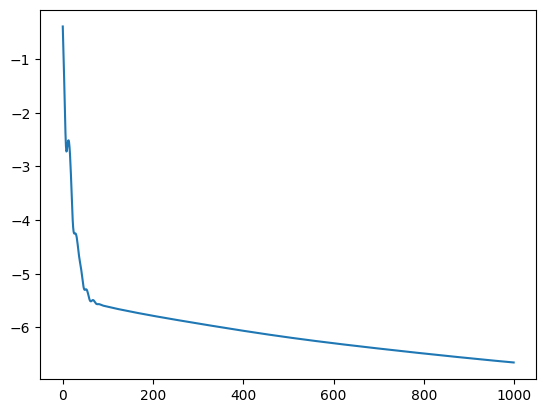

In [4]:
# Generate some training data
key = jax.random.PRNGKey(0)
x_train = inputs
y_train = outputs

# Initialise the model and optimiser
model = SimpleNN()
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = model.apply(params, x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
loss = []
for i in tqdm(range(1000)):
  my_state, l = train_step(my_state, x_train, y_train)
  loss.append(jnp.log(l))

plt.plot(loss)
plt.show()

**Exercise:**

1. Check how close this NN is to being invariant under the projective rescaling.
2. Try to design a NN that is invariant under this projective rescaling.
3. Train that NN on the dataset, and compare the results.

In [5]:
# A1

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Function to check invariance
def check_invariance(model, params, inputs, scale):
    original_output = model.apply(params, inputs)
    scaled_inputs = inputs * scale
    scaled_output = model.apply(params, scaled_inputs)
    return jnp.allclose(original_output, scaled_output)

# Test the current model
scale_factor = 2.0
is_invariant = check_invariance(model, my_state.params, x_train, scale_factor)
print(f"Is the current NN invariant under projective rescaling? {is_invariant}")



Is the current NN invariant under projective rescaling? False


100%|██████████| 1000/1000 [00:07<00:00, 125.01it/s]


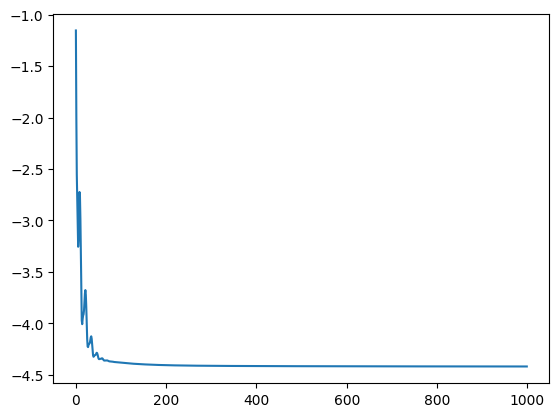

Is the projectively invariant NN invariant under projective rescaling? True


100%|██████████| 1000/1000 [00:05<00:00, 188.52it/s]


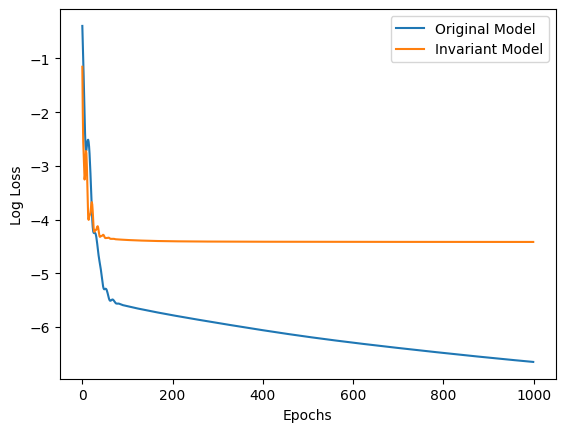

In [7]:
# A2

import flax.linen as nn
import jax.numpy as jnp
import jax
import optax
from flax.training import train_state
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the projectively invariant NN model
class ProjectivelyInvariantNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Normalize the inputs
        x = x / jnp.linalg.norm(x, axis=-1, keepdims=True)
        # Define the rest of the network
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the model and optimizer
key = jax.random.PRNGKey(0)
x_train = inputs  # Define your x_train data
y_train = outputs  # Define your y_train data

model_invariant = ProjectivelyInvariantNN()
params_invariant = model_invariant.init(jax.random.PRNGKey(2), x_train)
optimiser_invariant = optax.adam(learning_rate=0.01)
state_invariant = train_state.TrainState.create(
    apply_fn=model_invariant.apply,
    params=params_invariant,
    tx=optimiser_invariant)

# Define the loss function
def loss_fn_invariant(params, x, y):
    y_pred = model_invariant.apply(params, x)
    loss = jnp.mean((y_pred - y) ** 2)
    return loss

# Define the training step
@jax.jit
def train_step_invariant(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn_invariant)
    loss, grads = grad_fn(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Train the invariant model
loss_invariant = []
for i in tqdm(range(1000)):
    state_invariant, l = train_step_invariant(state_invariant, x_train, y_train)
    loss_invariant.append(jnp.log(l))

plt.plot(loss_invariant)
plt.show()

# Function to check invariance
def check_invariance(model, params, inputs, scale):
    original_output = model.apply(params, inputs)
    scaled_inputs = inputs * scale
    scaled_output = model.apply(params, scaled_inputs)
    return jnp.allclose(original_output, scaled_output)

# Test the invariant model
scale_factor = 2.0
is_invariant = check_invariance(model_invariant, state_invariant.params, x_train, scale_factor)
print(f"Is the projectively invariant NN invariant under projective rescaling? {is_invariant}")

# Train the original model
model = SimpleNN()  # Define your original SimpleNN model
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
    y_pred = model.apply(params, x)
    loss = jnp.mean((y_pred - y) ** 2)
    return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Train the original model
loss_original = []
for i in tqdm(range(1000)):
    my_state, l = train_step(my_state, x_train, y_train)
    loss_original.append(jnp.log(l))

# Plot the loss curves for comparison
plt.plot(loss_original, label='Original Model')
plt.plot(loss_invariant, label='Invariant Model')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


100%|██████████| 1000/1000 [00:08<00:00, 123.86it/s]


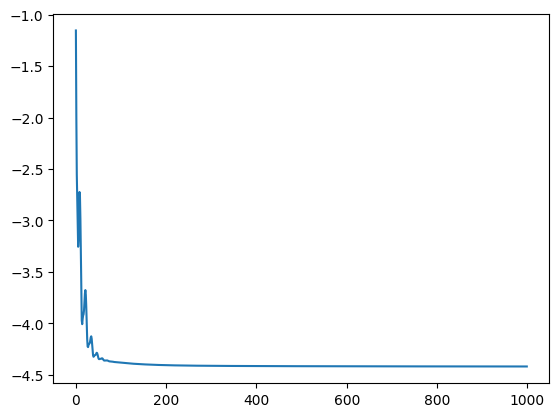

Is the projectively invariant NN invariant under projective rescaling? True


100%|██████████| 1000/1000 [00:05<00:00, 188.47it/s]


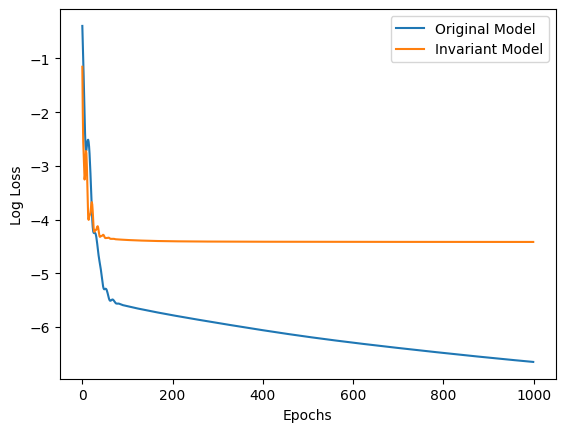

In [8]:
#Answer 3

import flax.linen as nn
import jax.numpy as jnp
import jax
import optax
from flax.training import train_state
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the projectively invariant NN model
class ProjectivelyInvariantNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Normalize the inputs
        x = x / jnp.linalg.norm(x, axis=-1, keepdims=True)
        # Define the rest of the network
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the model and optimizer
key = jax.random.PRNGKey(0)
x_train = inputs  # Define your x_train data
y_train = outputs  # Define your y_train data

model_invariant = ProjectivelyInvariantNN()
params_invariant = model_invariant.init(jax.random.PRNGKey(2), x_train)
optimiser_invariant = optax.adam(learning_rate=0.01)
state_invariant = train_state.TrainState.create(
    apply_fn=model_invariant.apply,
    params=params_invariant,
    tx=optimiser_invariant)

# Define the loss function
def loss_fn_invariant(params, x, y):
    y_pred = model_invariant.apply(params, x)
    loss = jnp.mean((y_pred - y) ** 2)
    return loss

# Define the training step
@jax.jit
def train_step_invariant(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn_invariant)
    loss, grads = grad_fn(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Train the invariant model
loss_invariant = []
for i in tqdm(range(1000)):
    state_invariant, l = train_step_invariant(state_invariant, x_train, y_train)
    loss_invariant.append(jnp.log(l))

plt.plot(loss_invariant)
plt.show()

# Function to check invariance
def check_invariance(model, params, inputs, scale):
    original_output = model.apply(params, inputs)
    scaled_inputs = inputs * scale
    scaled_output = model.apply(params, scaled_inputs)
    return jnp.allclose(original_output, scaled_output)

# Test the invariant model
scale_factor = 2.0
is_invariant = check_invariance(model_invariant, state_invariant.params, x_train, scale_factor)
print(f"Is the projectively invariant NN invariant under projective rescaling? {is_invariant}")

# Train the original model
model = SimpleNN()  # Define your original SimpleNN model
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
    y_pred = model.apply(params, x)
    loss = jnp.mean((y_pred - y) ** 2)
    return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Train the original model
loss_original = []
for i in tqdm(range(1000)):
    my_state, l = train_step(my_state, x_train, y_train)
    loss_original.append(jnp.log(l))

# Plot the loss curves for comparison
plt.plot(loss_original, label='Original Model')
plt.plot(loss_invariant, label='Invariant Model')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()


# Learning Sections of Line Bundles over Projective Spaces

We can learn sections of line bundles over projective spaces—don't worry if you don't know what a line bundle is.

For $\mathbb{P}_1$, we label a line bundle as $O(k)$, with $k \in \mathbb{Z}$.

A section of this line bundle transforms under projective rescalings as:
$$
\sigma(\lambda \vec{Z}) = \lambda^{k_4} \sigma(\vec{Z})
$$

In [9]:
import pickle
with open("sectData.pkl", "rb") as f:
    inputs, outputs = pickle.load(f)

print(inputs[0],outputs[0])


[ 1.1597246   1.2696937  -0.55691326  0.20402706] [ 0.02591452 -0.33085796]


This dataset is for a section of $O(2)$.

The input is listed the same as last time, and the output is $[\text{Re}(\sigma), \text{Im}(\sigma)]$.

Let's train a NN to learn this section.

100%|██████████| 1000/1000 [00:05<00:00, 175.55it/s]


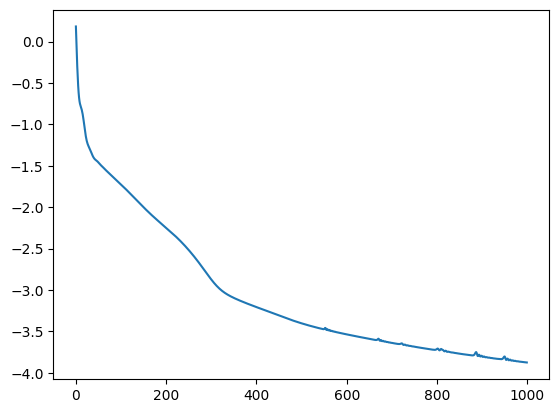

In [10]:
# Generate some training data
key = jax.random.PRNGKey(0)
x_train = inputs
y_train = outputs

# Initialise the model and optimiser
model = SimpleNN()
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = model.apply(params, x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
loss = []
for i in tqdm(range(1000)):
  my_state, l = train_step(my_state, x_train, y_train)
  loss.append(jnp.log(l))

plt.plot(loss)
plt.show()

**Exercise:**

1. Check how close this NN is to being invariant under the projective rescaling.
2. Try to design a NN that is appropriately equivariant under this projective rescaling.
3. Train that NN on the dataset, and compare the results.

In [11]:
# Step 1 - Check if the NN is invariant under projective rescaling

# Function to check invariance
def check_invariance(model, params, inputs, scale):
    original_output = model.apply(params, inputs)
    scaled_inputs = inputs * scale
    scaled_output = model.apply(params, scaled_inputs)
    return jnp.allclose(original_output, scaled_output, atol=1e-5)

# Test the current model for invariance
scale_factor = 2.0
is_invariant = check_invariance(model, my_state.params, x_train, scale_factor)
print(f"Is the current NN invariant under projective rescaling? {is_invariant}")


Is the current NN invariant under projective rescaling? False


100%|██████████| 1000/1000 [00:08<00:00, 121.76it/s]


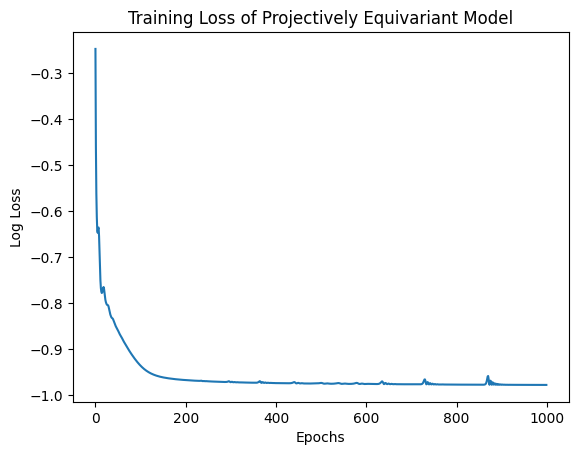

In [13]:
# Step 2 - Train the projectively invariant NN

class ProjectivelyEquivariantNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Normalize the inputs
        x = x / (jnp.linalg.norm(x, axis=-1, keepdims=True) + 1e-6)  # Add epsilon to avoid division by zero
        # Define the rest of the network
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the projectively equivariant model and optimizer
model_equivariant = ProjectivelyEquivariantNN()
params_equivariant = model_equivariant.init(jax.random.PRNGKey(2), x_train)
optimiser_equivariant = optax.adam(learning_rate=0.01)
state_equivariant = train_state.TrainState.create(
    apply_fn=model_equivariant.apply,
    params=params_equivariant,
    tx=optimiser_equivariant
)

# Define the loss function for the equivariant model
def loss_fn_equivariant(params, x, y):
    y_pred = model_equivariant.apply(params, x)
    loss = jnp.mean((y_pred - y) ** 2)
    return loss

# Define the training step for the equivariant model
@jax.jit
def train_step_equivariant(state, x, y):
    grad_fn = jax.value_and_grad(loss_fn_equivariant)
    loss, grads = grad_fn(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Train the projectively equivariant model
loss_equivariant = []
for i in tqdm(range(1000)):
    state_equivariant, l = train_step_equivariant(state_equivariant, x_train, y_train)
    loss_equivariant.append(jnp.log(l))

plt.plot(loss_equivariant)
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training Loss of Projectively Equivariant Model')
plt.show()


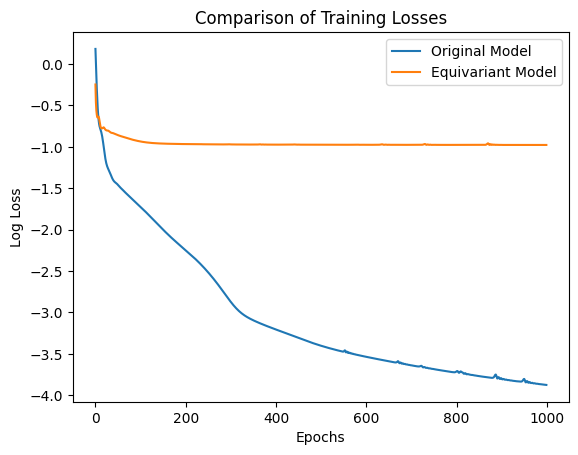

In [14]:
# Plot the loss curves for comparison
plt.plot(loss, label='Original Model')
plt.plot(loss_equivariant, label='Equivariant Model')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.title('Comparison of Training Losses')
plt.show()
